# Hierarchical characterisation plots




In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import scipy.cluster.hierarchy as sh
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress
import collections
import cPickle as pickle

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import hierarchicalrandomnetwork

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

# Exploration of parameters controlling weights and threshold

This is to show the effect of lambda, p and theta.

Lambda is actually not used... it cancels out :P

Done in [this notebook](../hierarchical_network_characterisation/notebook_hierarchical_weights_1try_270818.ipynb)

# Weights distribution plots

In [9]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='none',
    N=200,
    num_samples=50,
    label='thesis_hierarchical_weights',
    output_directory='./Figures/thesis/hierarchical_weights/',
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    M=100,
    code_type='hierarchical',
    type_layer_one='feature',
    output_both_layers=None,
    ratio_hierarchical=0.3,
    normalise_weights=1,
    threshold=1.0,
    sigmax=0.3,
    sigmay=0.000001,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.17,    
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network

sampler.fit_mixture_model()

{'K': 0.0,
 'aic': 743.14990835762228,
 'bic': 756.34317782381447,
 'kappa': 23.581529573635692,
 'mixt_nontargets': 0.0,
 'mixt_nontargets_sum': 0.0,
 'mixt_random': 0.99918949195091411,
 'mixt_target': 0.00081050804908573335,
 'train_LL': -367.57495417881114}

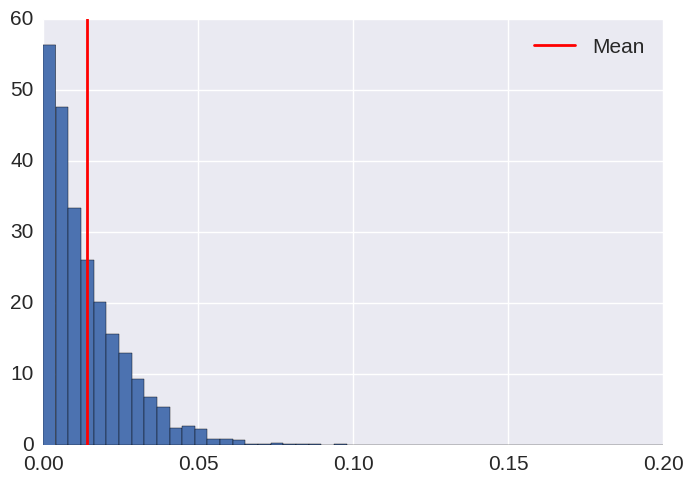

In [10]:
weights = network.A_sampling

f, ax = plt.subplots()
ax.hist(weights.flatten(), bins=np.linspace(0, 0.2, 50), normed=True)
ax.axvline(np.mean(weights), color='r')
ax.legend(['Mean'])

# f.savefig(dataio.create_formatted_filename("hist_weights_{label}_{unique_id}.pdf"))

Average number of input neurons:
10.3


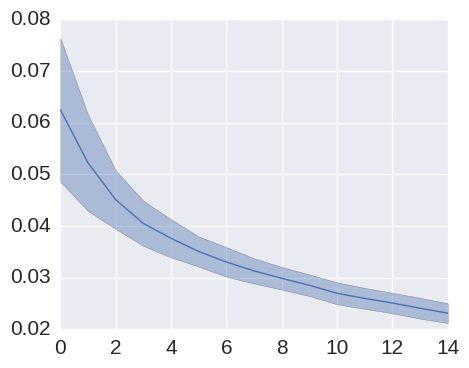

In [19]:
# Average weights coming in, sorted.
sorted_weights = np.sort(weights, axis=-1)[:, -15:]
weights_mean = np.mean(sorted_weights, axis=0)[::-1]
weights_std = np.std(sorted_weights, axis=0)[::-1]

_, ax = plt.subplots(figsize=(5, 4))
utils.plot_mean_std_area(np.arange(weights_mean.size), weights_mean, weights_std, ax_handle=ax)

print "Average number of input neurons:"
print np.mean(np.sum(weights > (np.mean(weights) + 1*np.std(weights)), axis=1))

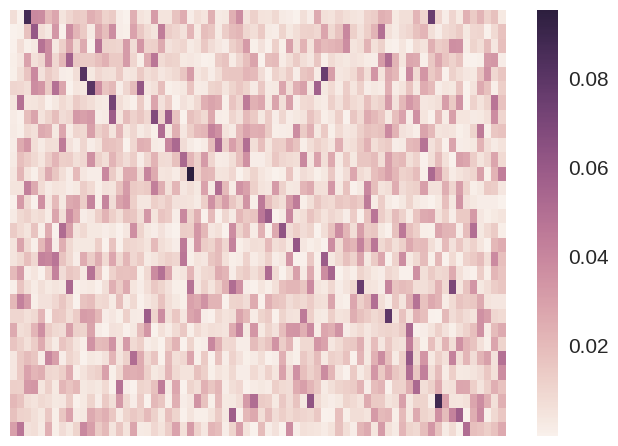

In [11]:
sns.heatmap(weights[np.argsort(np.argmax(weights, axis=-1))], xticklabels=False, yticklabels=False)

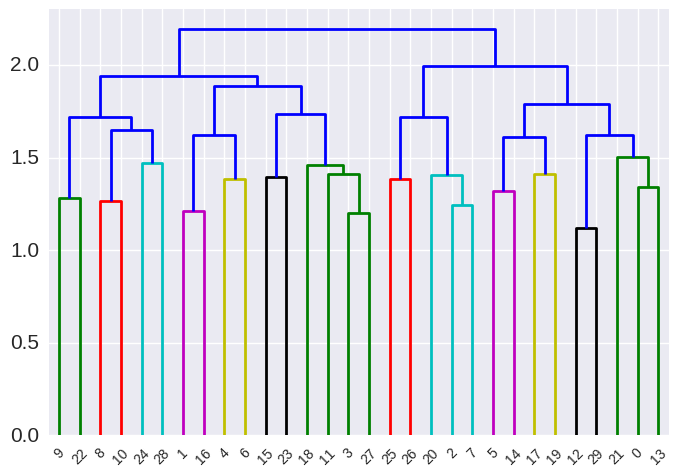

In [12]:
# Hierarchial clustering of weights
weights_nonzero = weights[np.any(weights > 0, axis=1)]
corr_weights = np.corrcoef(weights_nonzero)
corr_weights[np.isnan(corr_weights)] = 0

# dists = sh.distance.pdist(corr_weights)
cluster_hier = sh.linkage(corr_weights, method='complete')
cluster_index = sh.fcluster(cluster_hier, 0., 'distance')
sh.dendrogram(cluster_hier);

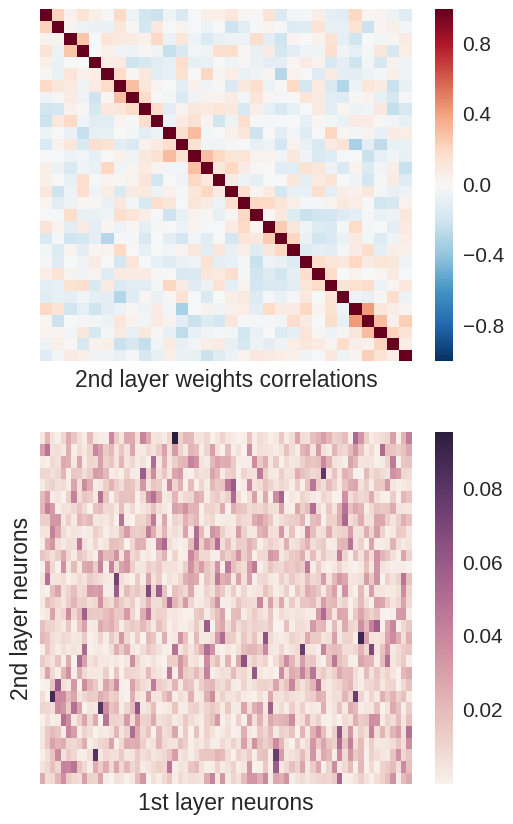

In [13]:
ordering = np.argsort(cluster_index)
f, axes = plt.subplots(2, 1, figsize=(6, 10))

sns.heatmap(corr_weights[ordering, :][:, ordering], xticklabels=False, yticklabels=False, ax=axes[0])
axes[0].set_xlabel('2nd layer weights correlations')

sns.heatmap(weights[ordering, :], xticklabels=False, yticklabels=False, ax=axes[1])
axes[1].set_xlabel('1st layer neurons')
axes[1].set_ylabel('2nd layer neurons')

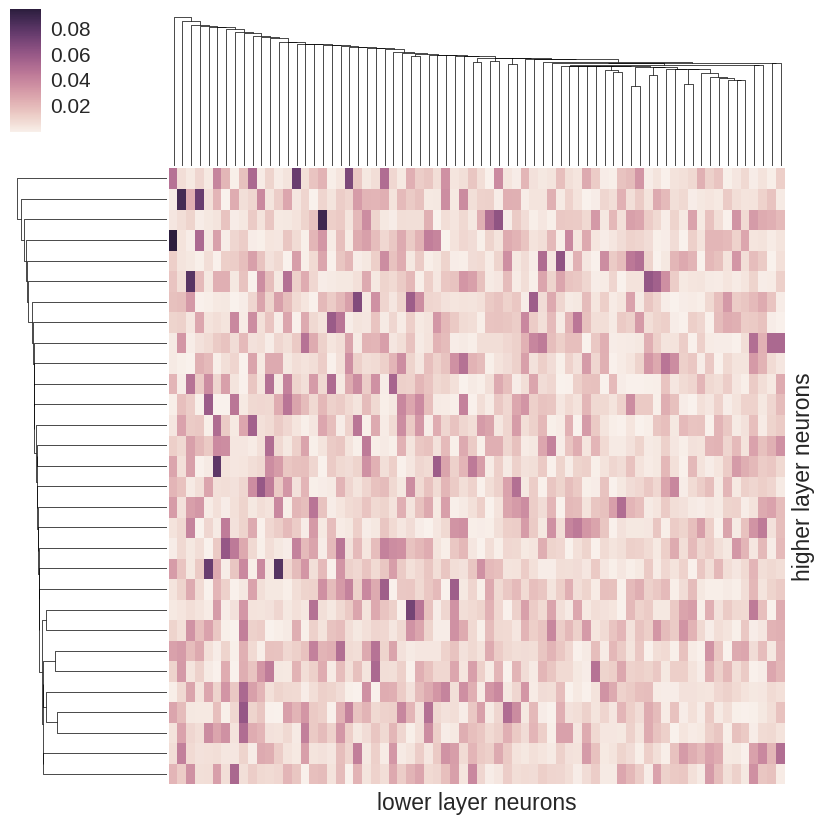

In [14]:
g = sns.clustermap(weights, method='single', xticklabels=False, yticklabels=False)
g.ax_heatmap.set_xlabel('lower layer neurons')
g.ax_heatmap.set_ylabel('higher layer neurons')

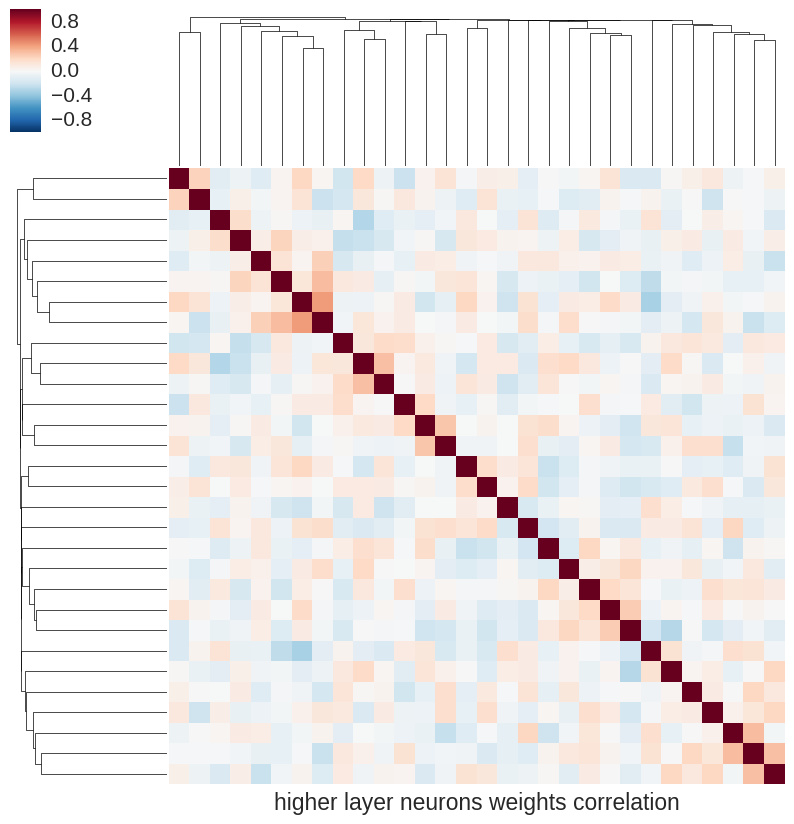

In [15]:
g = sns.clustermap(corr_weights, method='single', xticklabels=False, yticklabels=False)
g.ax_heatmap.set_xlabel('higher layer neurons weights correlation')

(0.057621536673940113, 0.010615254689460334)


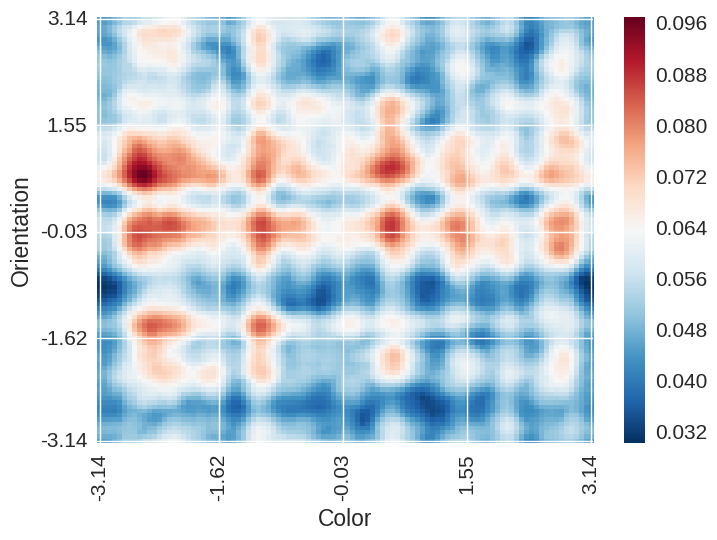

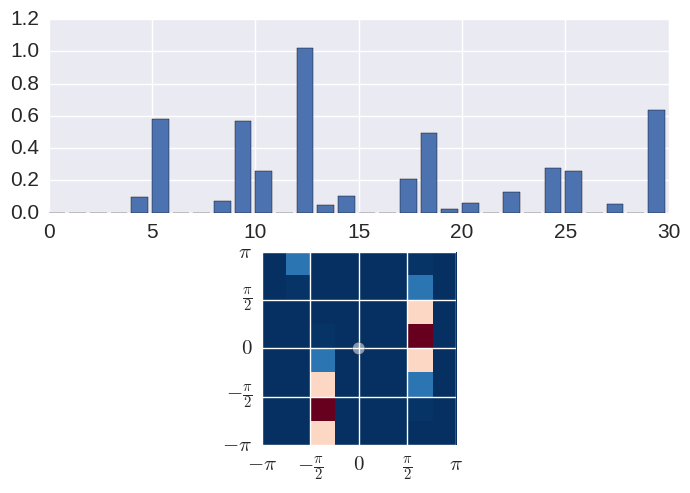

In [20]:
network.plot_mean_activity()
network.plot_network_activity()

# Average precision as a function of angle

In [23]:
# Precision as a function of the angle
df_avgstd, df_all = sampler.estimate_precision_per_angle(fit_mixture_model=False, num_repetitions=50, num_bins=20)

(-3.141592653589793, 3.141592653589793)

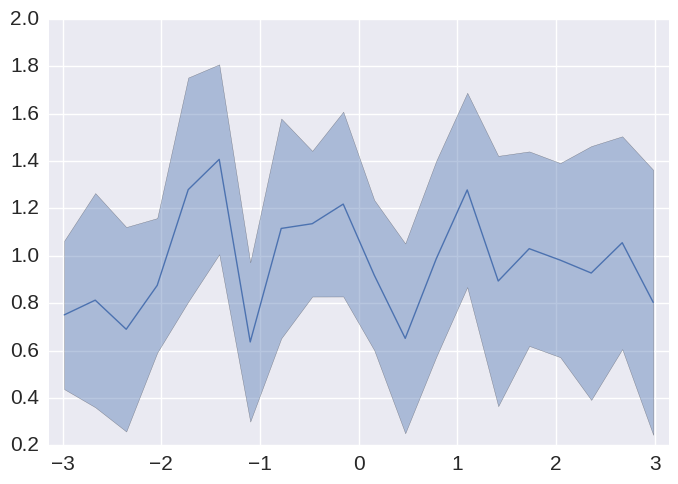

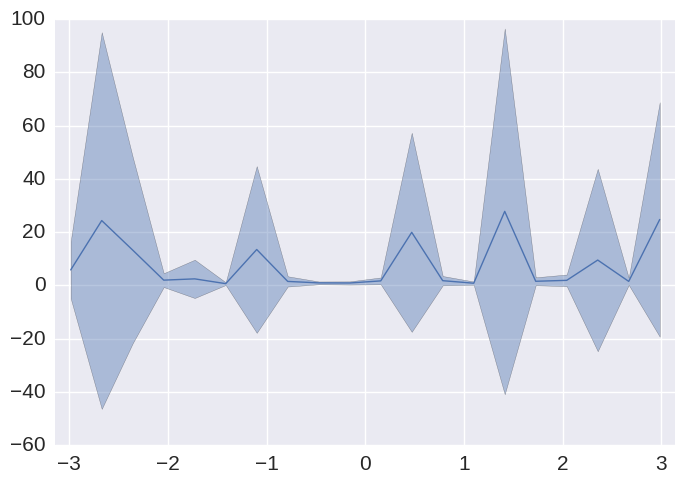

In [24]:
ax1 = utils.plot_mean_std_area(
    df_avgstd['angle_middle'], df_avgstd['precisions_stddev'], df_avgstd['precisions_stddev_std'])
ax2 = utils.plot_mean_std_area(
    df_avgstd['angle_middle'], df_avgstd['precisions'], df_avgstd['precisions_std'])

ax1.set_xlim((-np.pi, np.pi))
ax2.set_xlim((-np.pi, np.pi))

# 2D plot of M and ratio hierarchical

In [6]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    
    if "std_" + interpolate_column in df:
        w = 1./df["std_" + interpolate_column]
    else:
        w = None
        
    return spint.SmoothBivariateSpline(df[x_col], df[y_col], df[interpolate_column], w=w, kx=kx, ky=ky, s=s)

def pcolor_2d_interpolated(df, target_column, x_col='M', y_col='rc_scale', 
                           title='', vmin=None, vmax=None, cmap='RdBu_r'):
    x_int_space = np.sort(df[x_col].unique())
    y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col)
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                xlabel_format="%d", 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=15,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

In [7]:
%cd /nfs/data3/lmatthey/visual_working_mem/fit_mixturemodels/

with io.capture_output(display=False, stdout=True) as captured:
    %run reloader_fit_mixturemodels_hierarchical_Mratio_grid_270617.py

/nfs/data3/lmatthey/visual_working_mem/fit_mixturemodels


In [8]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']
all_args_arr = np.array(data_pbs.loaded_data['args_list'])

In [28]:
pandas_columns_with_processing = [
    ('result_all_precisions', dict(name='precision', process=utils.process_precision)),
    ('result_em_fits', dict(name='emfit', process=utils.process_em_fits)),
]

df_all_fits = utils.construct_pandas_dataframe(data_pbs, pandas_columns_with_processing, num_repetitions)
df_all_fits.loc[:, ('M')] = df_all_fits.loc[:, ('M')].astype(int)

M_space = np.sort(df_all_fits['M'].unique())
ratio_hier_space = np.sort(df_all_fits['ratio_hierarchical'].unique())


In [63]:
targets_fidelity = [500, 1000, 2000]
clip_distance = 200

for target_fidelity in targets_fidelity:
    df_all_fits.loc[:, 'emfit_fidelity_distance_{}'.format(target_fidelity)] = np.clip(
        df_all_fits.emfit_fidelity - target_fidelity, -clip_distance, clip_distance)

In [64]:
df_all_fits.describe()

,precision,std_precision,precision_stddev,emfit_kappa,emfit_target,emfit_nontargets,emfit_random,emfit_LL,emfit_bic,emfit_fidelity,emfit_stddev,std_emfit_kappa,std_emfit_fidelity,std_emfit_stddev,M,ratio_hierarchical,emfit_fidelity_distance_500,emfit_fidelity_distance_1000,emfit_fidelity_distance_2000
count,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.0,7.487000e+03,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000,7487.000000
mean,3991.736356,694.635522,0.159008,4023.599779,0.978108,0.0,2.189188e-02,374.139820,-732.384688,4023.096779,0.063166,692.560805,692.561226,0.010732,206.283558,0.481181,52.520356,8.087647,-37.207009
std,6430.506159,1188.558411,0.337546,6427.886042,0.081547,0.0,8.154744e-02,234.703870,469.407741,6427.887887,0.095922,1279.552250,1279.551968,0.044882,111.197136,0.281932,184.138111,195.622026,194.267326
min,0.152124,0.003705,0.007181,0.317672,0.012694,0.0,3.219017e-12,-367.432741,-1465.443641,0.269925,0.005074,0.079706,0.079963,0.000004,10.000000,0.000100,-200.000000,-200.000000,-200.000000
25%,174.330541,31.075074,0.020677,215.768604,0.997903,0.0,5.468535e-11,240.236260,-1097.722500,215.267632,0.014374,32.115339,32.115604,0.001099,110.000000,0.237450,-200.000000,-200.000000,-200.000000
50%,1091.233759,197.426089,0.044743,1129.929015,1.000000,0.0,5.665825e-10,413.611516,-811.328080,1129.428831,0.029756,175.152505,175.152567,0.002513,205.000000,0.474800,200.000000,129.428831,-200.000000
75%,4826.630930,808.944271,0.123725,4840.689843,1.000000,0.0,2.096762e-03,556.808726,-464.577567,4840.189800,0.068157,788.653812,788.653814,0.006522,302.500000,0.727300,200.000000,200.000000,200.000000
max,38834.377506,11031.307570,3.669424,38834.877512,1.000000,0.0,9.873059e-01,740.669297,750.760434,38834.377506,1.924769,40027.138423,40027.148950,1.011548,395.000000,0.989900,200.000000,200.000000,200.000000


In [65]:
# Remove outliers
df_fits_filtered = utils.remove_outliers(df_all_fits, 5)

In [66]:
# # First quantize Sigma_x and filter it out
# nQuantiles = 30
# parameters = ['sigmax']
# df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(df_fits_filtered, parameters, nQuantiles)
# df_fits_nosigmax = filter_quantized_param(df_quantized, {'sigmax': 0.3}, param_qbins).reset_index(drop=True)
# # Now quantize ratio_hierarchical
# nQuantiles = 50
# parameters = ['M', 'ratio_hierarchical']

# df_fits_nosigmax_quant, param_qbins, param_qbins_middle = df_add_quantize_parameters(
#     df_fits_nosigmax, parameters, nQuantiles)

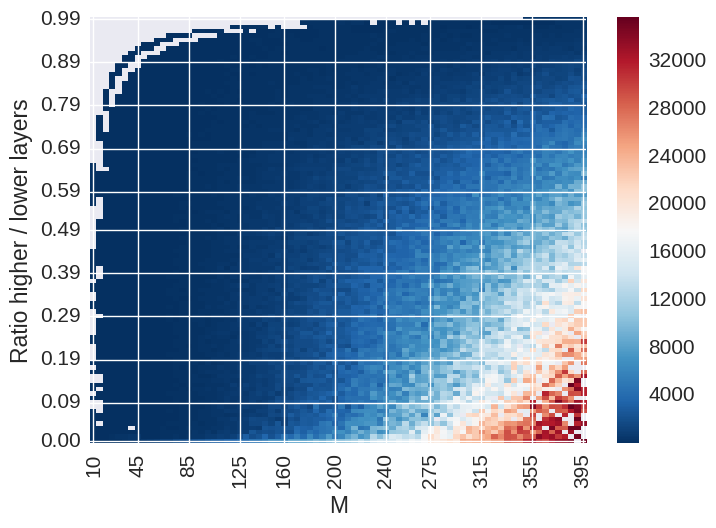

In [67]:
data_M_ratio = df_fits_filtered.pivot_table(index='M', 
                                            columns='ratio_hierarchical', 
                                            values='emfit_fidelity').as_matrix()

ax, _ = utils.pcolor_2d_data(data_M_ratio, x=M_space, y=ratio_hier_space, 
                             xlabel="M", ylabel="Ratio higher / lower layers", xlabel_format = "%d", 
                             ticks_interpolate=11, cmap='RdBu_r', log_scale=False)

In [68]:
# ax.get_figure().savefig(dataio.create_formatted_filename("hierarchical_2d_Mratio_{label}_{unique_id}.pdf"))

In [69]:
# Quantize parameters to smooth stuff up a bit

nQuantiles = 41
parameters = ['M', 'ratio_hierarchical']

df_fits_quants, param_qbins, param_qbins_middle = utils.df_add_quantize_parameters(
    df_fits_filtered, parameters, nQuantiles)
df_fits_q_avg = df_fits_quants.groupby(('M_qi', 'ratio_hierarchical_qi')).mean().reset_index()

In [70]:
# data_q_M_ratio = df_fits_q_avg.pivot_table(index='M_qi', 
#                                            columns='ratio_hierarchical_qi', 
#                                            values='emfit_fidelity'
#                                           ).as_matrix()

# ax, _ = utils.pcolor_2d_data(data_q_M_ratio, x=param_qbins_middle['M'], y=param_qbins_middle['ratio_hierarchical'], 
#                              xlabel="M", ylabel="Ratio higher / lower layers", xlabel_format = "%d", 
#                              ticks_interpolate=11, cmap='RdBu_r', log_scale=False)

In [71]:
cmap_div = sns.diverging_palette(h_neg=29, h_pos=265, s=80, l=85, sep=10, as_cmap=True, center='dark')

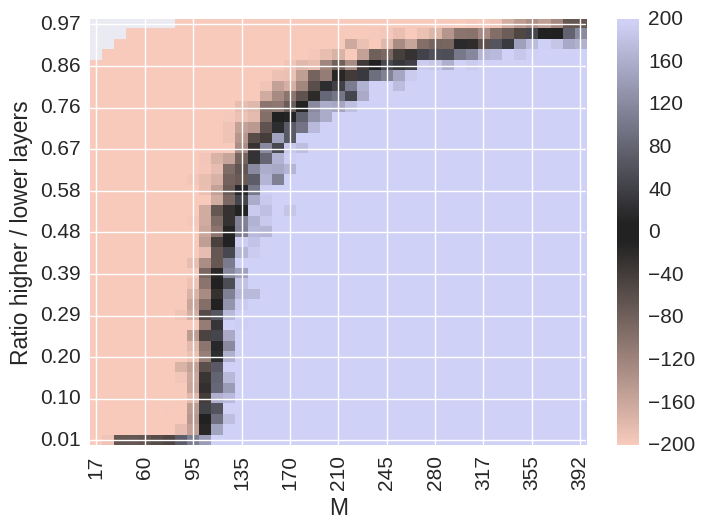

In [73]:
data_q_M_ratio = df_fits_q_avg.pivot_table(index='M_qi', 
                                           columns='ratio_hierarchical_qi', 
                                           values='emfit_fidelity_distance_500'
                                          ).as_matrix()

ax, _ = utils.pcolor_2d_data(data_q_M_ratio, x=param_qbins_middle['M'], y=param_qbins_middle['ratio_hierarchical'], 
                             xlabel="M", ylabel="Ratio higher / lower layers", xlabel_format = "%d", 
                             ticks_interpolate=11, cmap=cmap_div, log_scale=False)